## GNN_DTI Based Learning

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader                                     
from gnn import gnn
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import utils
from train_tools import *
import os, time, shutil, itertools, sys, random
from IPython.display import clear_output

In [18]:
class Opts: pass

### Options

In [19]:
gnn_opts = Opts()
gnn_opts.n_graph_layer = 4
gnn_opts.d_graph_layer = 140
gnn_opts.n_FC_layer = 4
gnn_opts.d_FC_layer = 128
gnn_opts.initial_mu = 4.46108546619827
gnn_opts.initial_dev = 0.19818493842903845
gnn_opts.dropout_rate = 0.05

In [20]:
learn_opts = Opts()
learn_opts.num_epochs = 1000
learn_opts.lr = 0.001
learn_opts.batch_size = 128

In [21]:
myopts = Opts()
myopts.data_fpath = 'cbidata'
myopts.save_dir = 'save'
#!Important: For production, random train and test may be preferred
myopts.random_stratify = True
myopts.cache_dir = '/tmp/moldata'
#Important! If you repeat experiments within the same dataset version, set to False
myopts.clear_cache = False
myopts.train_keys = 'keys/keys_klifs'
myopts.kinase_list = 'keys/kinase_list'
#Important!: The newest version is 3, still 1 and 2 are acceptible, 4 for silly atom feature disabling setup
myopts.dataset_version = 3
myopts.cpu_count = 10

In [22]:
__ver = myopts.dataset_version
assert __ver in list(range(1, 5))
if __ver == 1:
    import dataset as ds
elif __ver == 2:
    import dataset2 as ds
elif __ver ==  3:
    import dataset3 as ds
else:
    print('This is a silly setup, practically disabling atom features', file=sys.stderr)
    import dataset4 as ds

### Support functions for learning loop

In [23]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))
        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(np.array(test_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

def get_stats(X, y):
    rmse = metrics.mean_squared_error(X, y)**0.5
    mae = metrics.mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

def update_train_loss(train_loss, best_train_loss):
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    return best_train_loss

def update_test_loss(model, opts, test_loss, best_val_loss, epoch):
    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        output = True
    if output:
        torch.save(model.state_dict(), f'{opts.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{opts.save_dir}/model_weights.pt')
    return best_val_loss, output

### Setup

In [24]:
if myopts.clear_cache:
    try:
        shutil.rmtree(myopts.cache_dir)
    except:
        pass

In [25]:
os.makedirs(myopts.save_dir, exist_ok=True)

train = read_keyfile(myopts.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(train, random_stratify=myopts.random_stratify, kinase_check=False)

# random.shuffle(train_keys)
# random.shuffle(test_keys)

if True: # for testing with CPU
    train_keys = train_keys[:100]
    test_keys = test_keys[:30]

write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')

len(train_keys), len(test_keys), len(test2_keys)

(100, 30, 374)

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [27]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], myopts.data_fpath)
test_dataset = ds.MolDataset([k for k, v in test_keys], [v for k, v in test_keys], myopts.data_fpath)
len(train_dataset), len(test_dataset)

(100, 30)

In [28]:
gnn_opts.N_atom_features = train_dataset[0]['H'].shape[1]//2

In [14]:
train_dataloader = DataLoader(train_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)

### Start Learning

number of parameters :  214727
Epoch: 0	Lapse: 2.2s	Losses: (61.291, 51.590)	Best: (61.291, 51.590)


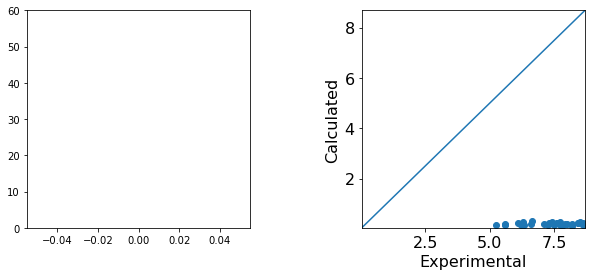

rmse: 7.183, mae: 7.121, r2: 0.120, rho: 0.131
--- Too many off-valued molecules (30/30) ---

Epoch: 1	Lapse: 2.4s	Losses: (53.737, 46.933)	Best: (53.737, 46.933)


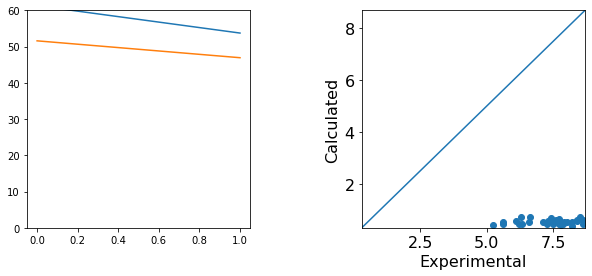

rmse: 6.851, mae: 6.787, r2: 0.133, rho: 0.147
--- Too many off-valued molecules (30/30) ---

Epoch: 2	Lapse: 2.7s	Losses: (48.599, 42.357)	Best: (48.599, 42.357)


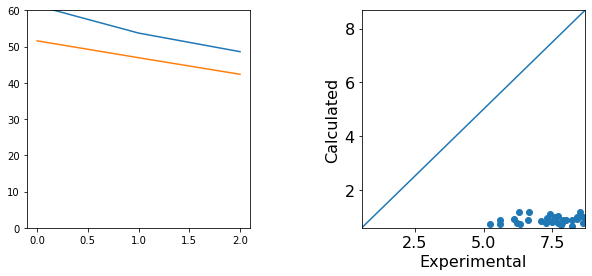

rmse: 6.508, mae: 6.441, r2: 0.134, rho: 0.140
--- Too many off-valued molecules (30/30) ---

Epoch: 3	Lapse: 2.7s	Losses: (43.880, 37.281)	Best: (43.880, 37.281)


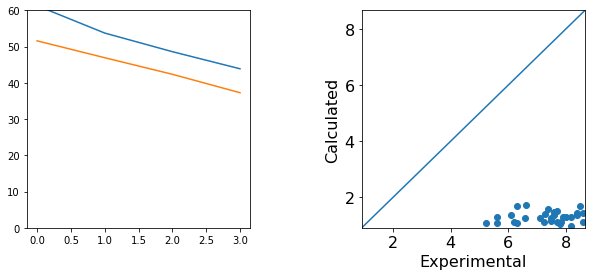

rmse: 6.106, mae: 6.034, r2: 0.136, rho: 0.152
--- Too many off-valued molecules (30/30) ---

Epoch: 4	Lapse: 2.5s	Losses: (38.256, 31.363)	Best: (38.256, 31.363)


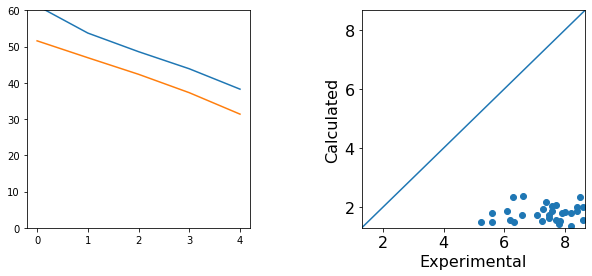

rmse: 5.600, mae: 5.520, r2: 0.137, rho: 0.169
--- Too many off-valued molecules (30/30) ---

Epoch: 5	Lapse: 3.0s	Losses: (32.529, 24.562)	Best: (32.529, 24.562)


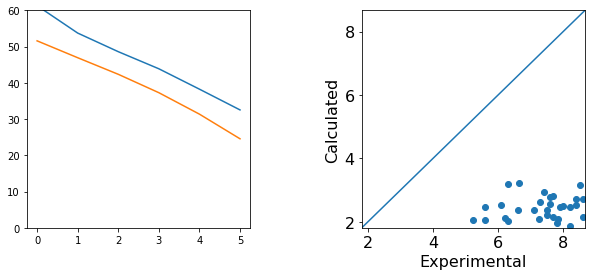

rmse: 4.956, mae: 4.862, r2: 0.140, rho: 0.178
--- Too many off-valued molecules (30/30) ---

Epoch: 6	Lapse: 2.9s	Losses: (24.601, 17.166)	Best: (24.601, 17.166)


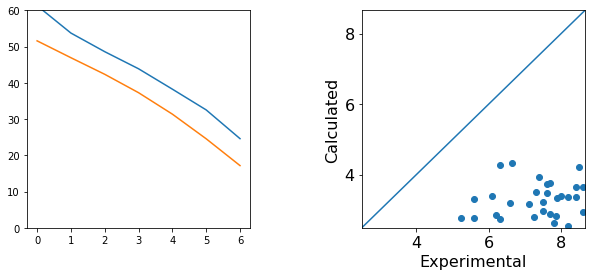

rmse: 4.143, mae: 4.023, r2: 0.147, rho: 0.183
--- Too many off-valued molecules (30/30) ---

Epoch: 7	Lapse: 3.2s	Losses: (17.028, 9.320)	Best: (17.028, 9.320)


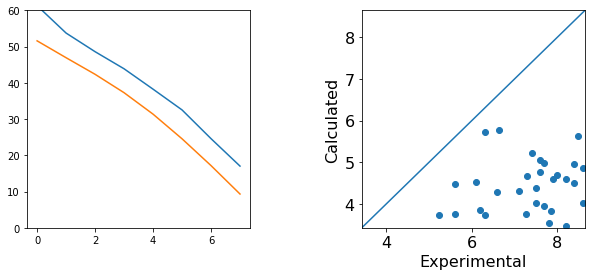

rmse: 3.053, mae: 2.869, r2: 0.161, rho: 0.203
--- Too many off-valued molecules (24/30) ---

Epoch: 8	Lapse: 3.0s	Losses: (8.960, 2.738)	Best: (8.960, 2.738)


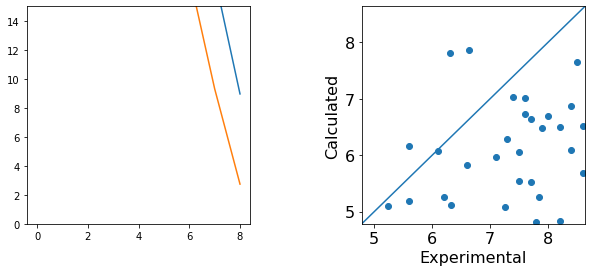

rmse: 1.655, mae: 1.421, r2: 0.195, rho: 0.218


5HBE,8.600,6.515,-2.085
5D9K,8.400,6.090,-2.310
3F88,8.600,5.677,-2.923
4D0W,7.700,5.529,-2.171
4I5C,7.850,5.267,-2.583
3LXN,7.265,5.090,-2.175
4MBI,8.200,4.824,-3.376
3Q3B,7.800,4.821,-2.979


Epoch: 9	Lapse: 3.2s	Losses: (2.988, 3.839)	Best: (2.988, 2.738)
Epoch: 10	Lapse: 3.2s	Losses: (6.242, 5.825)	Best: (2.988, 2.738)
Epoch: 11	Lapse: 3.3s	Losses: (7.647, 1.888)	Best: (2.988, 1.888)


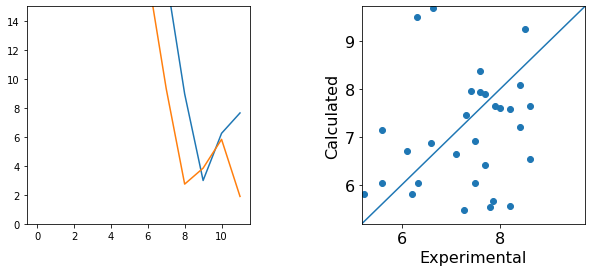

rmse: 1.374, mae: 1.053, r2: 0.181, rho: 0.217


2J2I,6.633,9.684,3.051
3ZEW,6.300,9.514,3.214
3F88,8.600,6.544,-2.056
4I5C,7.850,5.652,-2.198
4MBI,8.200,5.553,-2.647
3Q3B,7.800,5.544,-2.256


Epoch: 12	Lapse: 3.0s	Losses: (2.353, 2.185)	Best: (2.353, 1.888)
Epoch: 13	Lapse: 3.1s	Losses: (2.332, 2.490)	Best: (2.332, 1.888)
Epoch: 14	Lapse: 3.2s	Losses: (2.550, 2.608)	Best: (2.332, 1.888)
Epoch: 15	Lapse: 3.5s	Losses: (2.637, 2.542)	Best: (2.332, 1.888)
Epoch: 16	Lapse: 3.3s	Losses: (2.259, 2.366)	Best: (2.259, 1.888)
Epoch: 17	Lapse: 3.4s	Losses: (2.316, 2.196)	Best: (2.259, 1.888)
Epoch: 18	Lapse: 3.4s	Losses: (2.380, 2.094)	Best: (2.259, 1.888)
Epoch: 19	Lapse: 3.3s	Losses: (2.544, 2.090)	Best: (2.259, 1.888)
Epoch: 20	Lapse: 3.5s	Losses: (2.393, 2.090)	Best: (2.259, 1.888)
Epoch: 21	Lapse: 3.4s	Losses: (2.118, 2.080)	Best: (2.118, 1.888)
Epoch: 22	Lapse: 3.4s	Losses: (2.130, 2.072)	Best: (2.118, 1.888)
Epoch: 23	Lapse: 3.3s	Losses: (2.085, 2.054)	Best: (2.085, 1.888)
Epoch: 24	Lapse: 3.4s	Losses: (1.936, 2.015)	Best: (1.936, 1.888)
Epoch: 25	Lapse: 3.4s	Losses: (1.877, 1.977)	Best: (1.877, 1.888)
Epoch: 26	Lapse: 3.3s	Losses: (2.224, 1.946)	Best: (1.877, 1.888)
Epoch: 27	

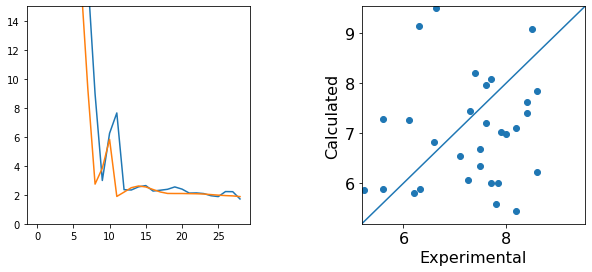

rmse: 1.370, mae: 1.113, r2: 0.125, rho: 0.153


2J2I,6.633,9.494,2.861
3ZEW,6.300,9.152,2.852
3F88,8.600,6.215,-2.385
3Q3B,7.800,5.579,-2.221
4MBI,8.200,5.438,-2.762


Epoch: 29	Lapse: 3.1s	Losses: (1.798, 1.790)	Best: (1.712, 1.790)


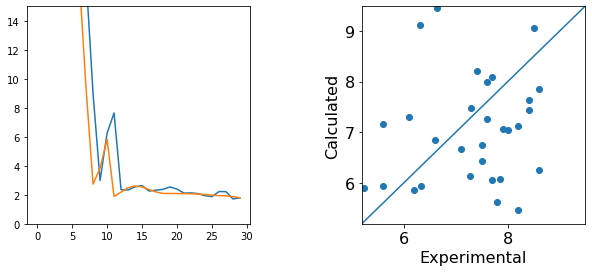

rmse: 1.338, mae: 1.082, r2: 0.136, rho: 0.160


2J2I,6.633,9.445,2.812
3ZEW,6.300,9.113,2.813
3F88,8.600,6.256,-2.344
3Q3B,7.800,5.615,-2.185
4MBI,8.200,5.460,-2.740


Epoch: 30	Lapse: 3.5s	Losses: (1.969, 1.740)	Best: (1.712, 1.740)


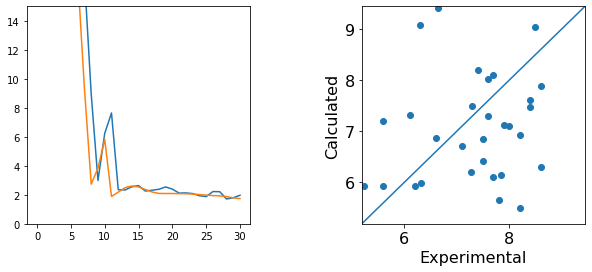

rmse: 1.319, mae: 1.064, r2: 0.135, rho: 0.161


2J2I,6.633,9.405,2.772
3ZEW,6.300,9.075,2.775
3F88,8.600,6.308,-2.292
3Q3B,7.800,5.659,-2.141
4MBI,8.200,5.493,-2.707


Epoch: 31	Lapse: 3.2s	Losses: (1.678, 1.679)	Best: (1.678, 1.679)


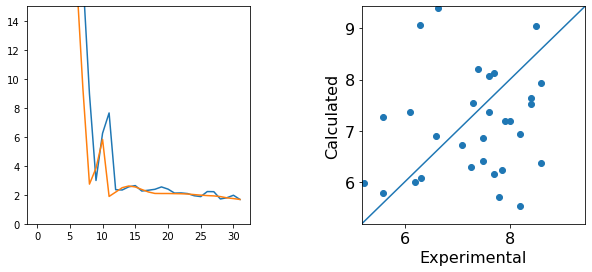

rmse: 1.296, mae: 1.038, r2: 0.146, rho: 0.168


2J2I,6.633,9.386,2.753
3ZEW,6.300,9.058,2.758
3F88,8.600,6.373,-2.227
3Q3B,7.800,5.718,-2.082
4MBI,8.200,5.539,-2.661


Epoch: 32	Lapse: 3.1s	Losses: (1.665, 1.619)	Best: (1.665, 1.619)


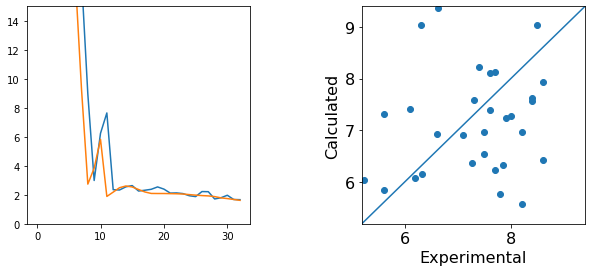

rmse: 1.272, mae: 1.010, r2: 0.145, rho: 0.176


2J2I,6.633,9.355,2.722
3ZEW,6.300,9.026,2.726
3F88,8.600,6.416,-2.184
3Q3B,7.800,5.768,-2.032
4MBI,8.200,5.564,-2.636


Epoch: 33	Lapse: 3.3s	Losses: (1.652, 1.585)	Best: (1.652, 1.585)


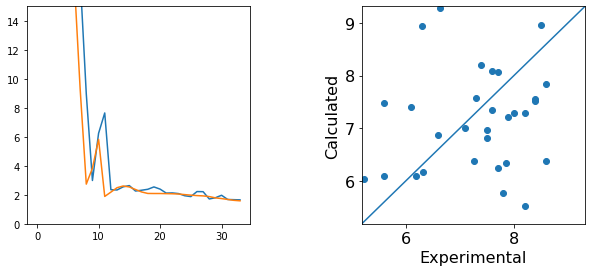

rmse: 1.259, mae: 0.994, r2: 0.125, rho: 0.153


2J2I,6.633,9.275,2.642
3ZEW,6.300,8.940,2.640
3F88,8.600,6.382,-2.218
3Q3B,7.800,5.768,-2.032
4MBI,8.200,5.531,-2.669


Epoch: 34	Lapse: 3.2s	Losses: (1.595, 1.588)	Best: (1.595, 1.585)
Epoch: 35	Lapse: 3.4s	Losses: (1.357, 1.554)	Best: (1.357, 1.554)


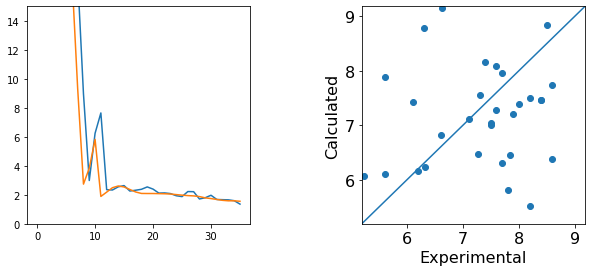

rmse: 1.247, mae: 0.965, r2: 0.099, rho: 0.130


2J2I,6.633,9.144,2.511
3ZEW,6.300,8.790,2.490
4MBJ,5.600,7.880,2.280
3F88,8.600,6.374,-2.226
4MBI,8.200,5.512,-2.688


Epoch: 36	Lapse: 3.1s	Losses: (1.398, 1.520)	Best: (1.357, 1.520)


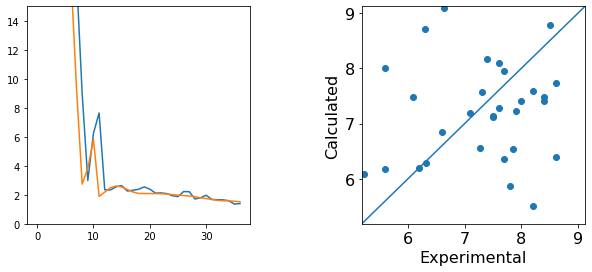

rmse: 1.233, mae: 0.947, r2: 0.088, rho: 0.107


2J2I,6.633,9.079,2.446
3ZEW,6.300,8.706,2.406
4MBJ,5.600,8.001,2.401
3F88,8.600,6.391,-2.209
4MBI,8.200,5.511,-2.689


Epoch: 37	Lapse: 3.4s	Losses: (1.697, 1.487)	Best: (1.357, 1.487)


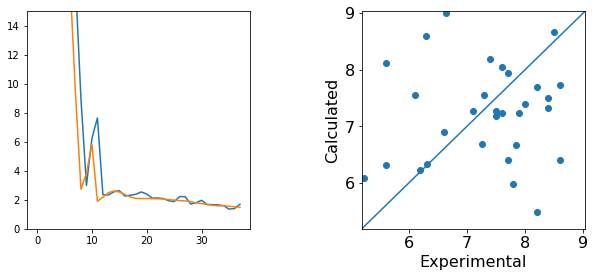

rmse: 1.219, mae: 0.931, r2: 0.074, rho: 0.086


2J2I,6.633,8.992,2.359
3ZEW,6.300,8.595,2.295
4MBJ,5.600,8.115,2.515
3F88,8.600,6.399,-2.201
4MBI,8.200,5.487,-2.713


Epoch: 38	Lapse: 3.1s	Losses: (1.380, 1.447)	Best: (1.357, 1.447)


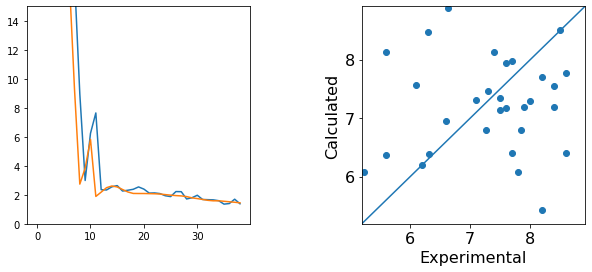

rmse: 1.203, mae: 0.914, r2: 0.065, rho: 0.073


2J2I,6.633,8.874,2.241
3ZEW,6.300,8.464,2.164
4MBJ,5.600,8.125,2.525
3F88,8.600,6.402,-2.198
4MBI,8.200,5.427,-2.773


Epoch: 39	Lapse: 3.2s	Losses: (1.221, 1.463)	Best: (1.221, 1.447)
Epoch: 40	Lapse: 3.3s	Losses: (1.300, 1.364)	Best: (1.221, 1.364)


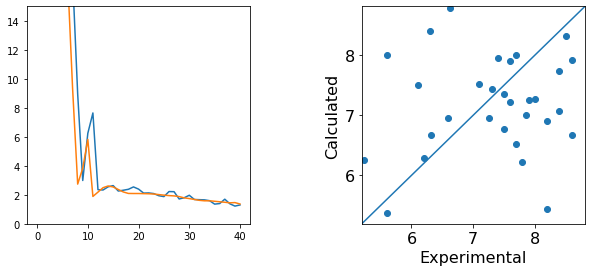

rmse: 1.168, mae: 0.907, r2: 0.118, rho: 0.055


2J2I,6.633,8.778,2.145
3ZEW,6.300,8.403,2.103
4MBJ,5.600,8.011,2.411
4MBI,8.200,5.433,-2.767


Epoch: 41	Lapse: 2.9s	Losses: (1.287, 1.342)	Best: (1.221, 1.342)


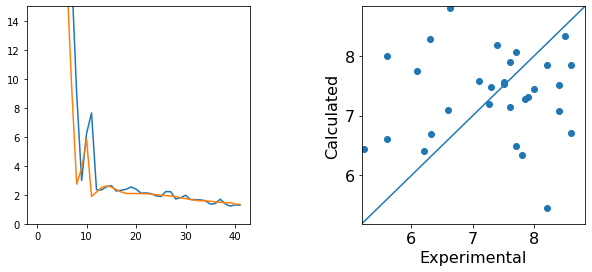

rmse: 1.158, mae: 0.890, r2: 0.039, rho: 0.021


2J2I,6.633,8.789,2.156
4MBJ,5.600,8.001,2.401
4MBI,8.200,5.452,-2.748


Epoch: 42	Lapse: 3.2s	Losses: (1.166, 1.379)	Best: (1.166, 1.342)
Epoch: 43	Lapse: 3.4s	Losses: (1.177, 1.408)	Best: (1.166, 1.342)
Epoch: 44	Lapse: 3.4s	Losses: (1.135, 1.400)	Best: (1.135, 1.342)
Epoch: 45	Lapse: 3.3s	Losses: (1.167, 1.393)	Best: (1.135, 1.342)
Epoch: 46	Lapse: 3.6s	Losses: (1.053, 1.388)	Best: (1.053, 1.342)
Epoch: 47	Lapse: 3.5s	Losses: (1.295, 1.393)	Best: (1.053, 1.342)
Epoch: 48	Lapse: 3.3s	Losses: (1.013, 1.373)	Best: (1.013, 1.342)


KeyboardInterrupt: 

In [15]:
CLEAR_OUTPUT_WHEN_UPDATE = False
SHOW_VERY_BAD_MOLS = True

model = utils.initialize_model(gnn(gnn_opts), device)
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=learn_opts.lr)
loss_fn = nn.MSELoss()
best_train_loss, best_val_loss = np.inf, np.inf

Los = []
Lps = []

for epoch in range(learn_opts.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    best_train_loss = update_train_loss(train_loss, best_train_loss)
    best_val_loss, output = update_test_loss(model, myopts, test_loss, best_val_loss, epoch)

    output = output or epoch == learn_opts.num_epochs - 1

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        L = list(itertools.chain.from_iterable(L))
        write_results_to_csv(L, X, y, np.abs(X-y), epoch)
        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))

    if output:
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')
        if SHOW_VERY_BAD_MOLS:
            show_bad_molecules(L, X, y, np.abs(X-y), len(X))